In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Sure Scheme/Segmentation 3/Track') # This path must contain this file, mask_funcs.py and utils.py

In [3]:
import numpy as np
import os
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import time
import sys
import torch
import gc
import cv2
from google.colab.patches import cv2_imshow
import torch.nn.functional as F

import mask_funcs
import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class MissingCell:
    def __init__(self, mask):
        self.mask = mask
        self.missing_count = 0

class Tracker:
    def __init__(self, name, mask_directory, image_directory, tracked_directory, view_tracks_directory, frame_memory = 3, overlap_threshold = 0.4):
        self.name = name
        self.mask_ims = sorted([mask for mask in (mask_directory).iterdir()])
        self.images = sorted([image for image in (image_directory).iterdir()])
        self.tracked_directory = tracked_directory
        self.view_tracks_directory = view_tracks_directory
        self.old_frame = torch.tensor(utils.read_tiff(self.mask_ims[0]).astype(np.int16)).to(device)
        self.new_frame = torch.tensor(utils.read_tiff(self.mask_ims[1]).astype(np.int16)).to(device)
        self.max_index = torch.max(self.old_frame)
        self.missing_cells = {} # key is cell index, value is instance of MissingCell class
        self.frame_memory = frame_memory
        self.overlap_threshold = overlap_threshold

    def add_missing_masks(self):
        for missing_index in self.missing_cells.keys():
            if missing_index not in self.old_frame:
                self.old_frame = torch.where(self.missing_cells[missing_index].mask.bool(), missing_index, self.old_frame)

    def update_new_frame(self):
        updated_new_frame = torch.zeros((600, 600)).to(device)
        self.add_missing_masks()
        for new_mask, mask_index in mask_funcs.SplitMask(self.new_frame):
            intersection = torch.logical_and(new_mask, self.old_frame != 0)
            indexes, counts = torch.unique(self.old_frame[intersection], return_counts=True)
            if len(indexes) > 0 and torch.max(counts) > self.overlap_threshold*torch.sum(new_mask):
                new_index = indexes[torch.argmax(counts)]
                self.old_frame = torch.where(self.old_frame==indexes[torch.argmax(counts)], 0, self.old_frame)
                if new_index in self.missing_cells:
                    del self.missing_cells[new_index]
            else:
                new_index = self.max_index + 1
                self.max_index = new_index
            updated_new_frame += new_mask*int(new_index)

        for missing_index in list(self.missing_cells.keys()):
            self.missing_cells[missing_index].missing_count += 1
            if self.missing_cells[missing_index].missing_count >= self.frame_memory:
                if missing_index in self.old_frame:
                    self.old_frame = torch.where(self.old_frame==missing_index, 0, self.old_frame)
                del self.missing_cells[missing_index]

        for missing_mask, missing_index in mask_funcs.SplitMask(self.old_frame):
            if missing_index not in self.missing_cells.keys():
                self.missing_cells[missing_index] = MissingCell(missing_mask)
        self.new_frame = updated_new_frame

    def track(self):
        print('\n--------------------\nTRACKING - ', self.name, '\n--------------------')

        utils.save_tiff(self.old_frame.to(dtype=torch.int16).cpu().numpy().astype(np.uint16),
                        self.tracked_directory / ("{0:04}".format(0) + '.tif'))

        for i in range(1, len(self.mask_ims)):
            sys.stdout.write(
                f'\rAdding frame {i+1} / {len(self.mask_ims)}')
            sys.stdout.flush()

            self.new_frame = torch.tensor(utils.read_tiff(self.mask_ims[i]).astype(np.int16)).to(device)
            self.update_new_frame()
            self.old_frame = self.new_frame
            utils.save_tiff(self.old_frame.to(dtype=torch.int16).cpu().numpy().astype(np.uint16), self.tracked_directory / ("{0:04}".format(i) + '.tif'))

    def show_tracks(self, num_frames=None):
        print('\n--------------------\nSHOWING TRACKS - ', self.name, '\n--------------------')
        self.tracked_masks = sorted([mask for mask in (self.tracked_directory).iterdir()])
        colour_dict = {}
        if num_frames is None:
            num_frames = len(self.tracked_masks)
        for i in range(num_frames):
            sys.stdout.write(
                f'\rAdding frame {i + 1} / {num_frames}')
            sys.stdout.flush()
            mask = torch.tensor(utils.read_tiff(self.tracked_masks[i]).astype(np.uint8)).to(device)
            im_rgb = torch.tensor(utils.read_tiff(self.images[i]).astype(np.int16)).to(device)
            #im_rgb = torch.stack((image, image, image), axis=0)
            #im_rgb = torch.tensor((image,image,image))
            #print(im_rgb[2])
            #print(im_rgb.shape) # 600 600 3
            im_rgb = im_rgb.permute(2, 0, 1)
            #im_rgb = image.permute(1, 2, 0).repeat(1, 1, 3)
          #  print(im_rgb.shape) # 3 600 600
          #  im_rgb = torch.stack((image, image, image), axis=0)
            for j in range(torch.max(mask)):
                if j+1 in mask:
                    if j+1 not in colour_dict.keys():
                        colour_dict[j+1] = torch.tensor(np.random.uniform(0, 2**(8)-1, size=3)).to(device)
                    single_mask = torch.where(mask==j+1, 1, 0)
                    outline = mask_funcs.mask_outline(single_mask, 3)
                    for c in range(3):
                        im_rgb[c] = torch.where(outline, colour_dict[j+1][c], im_rgb[c])
            im_rgb = im_rgb.permute(1, 2, 0)
           #print(im_rgb.shape)
            utils.save_tiff((im_rgb).cpu().numpy().astype(np.uint8), self.view_tracks_directory / ("{0:04}".format(i) + '.jpg'))

# create method to show which images/masks are being pulled from line in order to correct misalignment

Delete directory /content/drive/MyDrive/Sure Scheme/Segmentation 3/Track/Tracks? [y,n] y
Delete directory /content/drive/MyDrive/Sure Scheme/Segmentation 3/Track/show tracks? [y,n] y

--------------------
TRACKING -  Amoebas 
--------------------
Adding frame 10 / 10
--------------------
SHOWING TRACKS -  Amoebas 
--------------------
Adding frame 1 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 2 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 3 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 4 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 5 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 6 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 7 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 8 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 9 / 10torch.Size([3, 600, 600])
torch.Size([600, 600, 3])
Adding frame 10 / 10torc

(-0.5, 599.5, 599.5, -0.5)

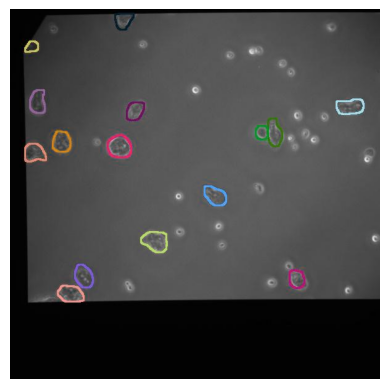

In [7]:
# inputs
mask_path = '/content/drive/MyDrive/Sure Scheme/Segmentation 3/Phase_masks/amoeba'
image_path = '/content/drive/MyDrive/Sure Scheme/Segmentation/Phase'

# output
tracked_path = '/content/drive/MyDrive/Sure Scheme/Segmentation 3/Track/Tracks'
view_tracks_path = '/content/drive/MyDrive/Sure Scheme/Segmentation 3/Track/show tracks'

utils.remake_dir(Path(tracked_path))
utils.remake_dir(Path(view_tracks_path))


my_tracker = Tracker('Amoebas', Path(mask_path), Path(image_path), Path(tracked_path), Path(view_tracks_path))
my_tracker.track()
my_tracker.show_tracks()

print(os.listdir(view_tracks_path)[0])


img = cv2.imread(os.path.join(view_tracks_path, os.listdir(view_tracks_path)[0]))
plt.imshow(img)
plt.axis("off")